In [1]:
get_ipython().magic(u'matplotlib inline')
%matplotlib tk
# tk needed for animation (could differ on Windows)
import mne
import pandas as pd
import numpy as np
from scipy import stats

import mnefaster as faster

In [2]:
### Create an appropriate raw object ###

# Read raw file
path = '/home/akkus/Documents/NumLab/EEG/Megosztott EEG/test1_data/'
raw = mne.io.read_raw_egi(path + 'Fanni 20110317 1104002.raw')

# Rename channels
raw.rename_channels(dict(zip(raw.ch_names, [ch_name.replace('EG ', '').replace('E0', 'E').replace('E0', 'E') for ch_name in raw.ch_names])))

# Set montage
mont = mne.channels.read_montage(kind='GSN-HydroCel-128')
raw.set_montage(mont)

# Define events in raw data (using stimulus-locked epochs here)
events = mne.find_events(raw, stim_channel='stim') 

log_data = pd.read_csv(path + 'Fanni 20110317 1104_2.csv', header=None, names=['onset', 'session', 'stim-resp', 'event_type', 'nothing'])

events[:, 2] = log_data[log_data['event_type']=='stim']['stim-resp']

event_id = [1,2,3,4,6,7,8,9]

# Optional: delete some events from the start/end of the session (to give relatively clean data to the ICA algorithm)
def crop_raw(raw, events, crop_size=3, samp_freq=1000):
    raw.crop(tmin=(events[crop_size][0]-50)/samp_freq, tmax=(events[len(events)-crop_size][0]-50)/samp_freq, copy=False)
    cropped_events = range(crop_size) + [len(events) - (i+1) for i in range(crop_size)]
    events = np.delete(events, cropped_events, axis=0)
    print 'Cropped %i events. Raw object now contains %i events.' %(len(cropped_events), len(events))
    return raw, events

raw, events = crop_raw(raw, events)

# Concatenating raw files
# raw, events = mne.concatenate_raws([raw0, raw1], events_list=[events0, events1])

# Set the correct type of channels #
def set_ch_type_gsn128(raw):
    stim_chs = ['STI 014', 'resp', 'stim']
    misc_chs = ['E17', 'E48', 'E119', 'E125', 'E126', 'E127', 'E128']
    eeg_chs = [ch for ch in raw.info['ch_names'] if ch not in stim_chs + misc_chs]
    for ch in eeg_chs:
        raw.set_channel_types({ch:'eeg'})
    for ch in misc_chs:
        raw.set_channel_types({ch:'misc'})
    return raw

raw = set_ch_type_gsn128(raw)

Reading EGI header from /home/akkus/Documents/NumLab/EEG/Megosztott EEG/test1_data/Fanni 20110317 1104002.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
320 events found
Events id: [1]
Cropped 6 events. Raw object now contains 314 events.


In [3]:
%%time
raw, bad_channels = faster.find_bad_channels(raw, mont)

Reading 0 ... 440000  =      0.000 ...   440.000 secs...
Applying a custom EEG reference.
Band-pass filtering from 4 - 30 Hz
Effective window size : 2.048 (s)
Converting time column to int64...
Interploating 2 bad channels (FASTER):
['E8', 'E25']


/usr/lib/python2.7/dist-packages/matplotlib/backend_managers.py:62: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well
  'version 2.1 and perhaps the rcParam as well')
/usr/lib/python2.7/dist-packages/matplotlib/backend_tools.py:78: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1, and some tools might change name
  'version 2.1, and some tools might change name')


Computing interpolation matrix from 118 sensor positions
Interpolating 2 sensors
CPU times: user 7.01 s, sys: 1.97 s, total: 8.98 s
Wall time: 1min 24s


In [4]:
%%time
epochs, bad_epochs = faster.find_bad_epochs(raw, events, event_id)

314 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 314 events and 2001 original time points ...
2 bad epochs dropped
Loading data for 312 events and 2001 original time points ...
Converting time column to int64...
Dropping 3 epochs (FASTER):
[172, 186, 269]
Dropped 3 epochs
CPU times: user 7.39 s, sys: 13.5 s, total: 20.9 s
Wall time: 53.7 s


In [5]:
%%time
ica, epochs = faster.fit_ica(epochs, len(bad_channels))

Loading data for 309 events and 2001 original time points ...
Applying a custom EEG reference.
Converting time column to int64...
Fitting ICA to data using 128 channels. 
Please be patient, this may take some time
Selection by number: 125 components
 
CPU times: user 7min 13s, sys: 7min 47s, total: 15min
Wall time: 4min 29s


In [6]:
%%time
epochs, bad_components = faster.find_bad_components(ica, epochs)

Converting time column to int64...
Converting time column to int64...
Subtracting 12 bad components (FASTER):
['ICA 001', 'ICA 007', 'ICA 013', 'ICA 022', 'ICA 023', 'ICA 002', 'ICA 003', 'ICA 017', 'ICA 020', 'ICA 011', 'ICA 016', 'ICA 024']
Transforming to ICA space (125 components)
Zeroing out 12 ICA components
CPU times: user 10.1 s, sys: 2.56 s, total: 12.7 s
Wall time: 31.7 s


In [7]:
%%time
evoked, bads_in_epochs = faster.find_bad_channels_in_epochs(epochs)

Converting time column to int64...
Computing interpolation matrix from 115 sensor positions
Interpolating 5 sensors
Computing interpolation matrix from 116 sensor positions
Interpolating 4 sensors
Computing interpolation matrix from 116 sensor positions
Interpolating 4 sensors
Computing interpolation matrix from 114 sensor positions
Interpolating 6 sensors
Computing interpolation matrix from 116 sensor positions
Interpolating 4 sensors
Computing interpolation matrix from 116 sensor positions
Interpolating 4 sensors
Computing interpolation matrix from 118 sensor positions
Interpolating 2 sensors
Computing interpolation matrix from 115 sensor positions
Interpolating 5 sensors
Computing interpolation matrix from 116 sensor positions
Interpolating 4 sensors
Computing interpolation matrix from 115 sensor positions
Interpolating 5 sensors
Computing interpolation matrix from 114 sensor positions
Interpolating 6 sensors
Computing interpolation matrix from 118 sensor positions
Interpolating 2 s

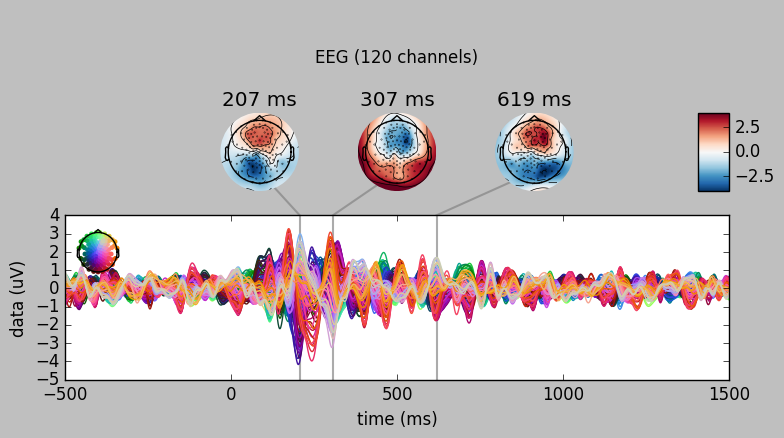

In [8]:
evoked.plot_joint()